<a href="https://colab.research.google.com/github/Zagreus98/PAIC_laborator/blob/main/Lab2_TACAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%cd drive/MyDrive/TACAI/
!pwd

/content/drive/MyDrive/TACAI
/content/drive/MyDrive/TACAI


In [3]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
base_path =  '/content/drive/MyDrive/TACAI/'

img_path_by_class = []
for i in range(4):
  c_p = base_path + str(i) + "/*.jpg"
  img_path_by_class.append(glob.glob(c_p))



In [5]:
img_path_by_class = np.array(img_path_by_class)
print(img_path_by_class.shape)
np.random.seed(42)
for path in img_path_by_class:
  np.random.shuffle(path)


(4, 10)


In [6]:
labels = []
for class_path in img_path_by_class:
  tmp = []
  for img_path in class_path:
    label = img_path.split('/')[5]
    tmp.append(label)
  labels.append(tmp)

print(labels)

[['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1'], ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2'], ['3', '3', '3', '3', '3', '3', '3', '3', '3', '3']]


In [7]:
train_paths = img_path_by_class[:,:7]
test_paths = img_path_by_class[:,7:]

train_imgs = []
test_imgs = []


for i in range(train_paths.shape[0]):
  tmp = []
  for j in range(train_paths.shape[1]):
    img = cv2.imread(train_paths[i][j])
    tmp.append(img)
  train_imgs.append(tmp)

for i in range(test_paths.shape[0]):
  tmp = []
  for j in range(test_paths.shape[1]):
    img = cv2.imread(test_paths[i][j])
    tmp.append(img)
  test_imgs.append(tmp)

print(train_imgs[0][0].shape)


(4032, 1908, 3)


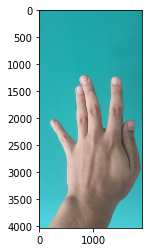

In [10]:
plt.figure()
plt.imshow(train_imgs[0][0][...,::-1])

In [8]:
height , width = train_imgs[0][0].shape[0] // 10, train_imgs[0][0].shape[1] // 10 
for i, cls in enumerate(train_imgs):
  for j, im in enumerate(cls):
    r = cv2.resize(im,(width,height))
    train_imgs[i][j] = r

for i, cls in enumerate(test_imgs):
  for j, im in enumerate(cls):
    r = cv2.resize(im,(width,height))
    test_imgs[i][j] = r



(403, 190, 3)


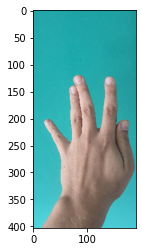

In [12]:
print(train_imgs[0][0].shape)
plt.figure()
plt.imshow(train_imgs[0][0][...,::-1])

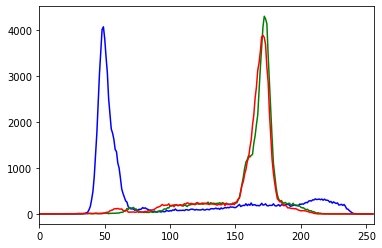

In [ ]:
color = ('b','g','r')
# de aici putem observa ca componenta de albastru nu ne ajuta
for i,col in enumerate(color):
    histr = cv2.calcHist([test_imgs[0][0][...,::-1]],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

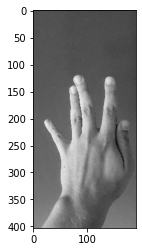

In [ ]:
# facut imaginile gray folosind doar R si G
train_g =[]
test_g =[]
for cls in train_imgs:
  tmp =[]
  for im in cls:
    mean = np.mean(im[...,1:],axis=2).astype(np.uint8)
    tmp.append(mean)
  train_g.append(tmp)
for cls in test_imgs:
  tmp =[]
  for im in cls:
    mean = np.mean(im[...,1:],axis=2).astype(np.uint8)
    tmp.append(mean)
  test_g.append(tmp)

plt.figure()
plt.imshow(train_g[0][0], cmap="gray")

Text(0.5, 1.0, 'Binary mask')

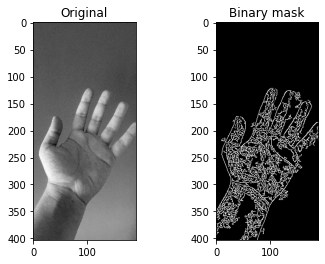

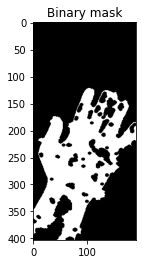

In [ ]:
img = train_g[3][0]
edges = cv2.Canny(img,10,80)
plt.figure(1)
plt.subplot(121); plt.imshow(img,cmap='gray');plt.title("Original")
plt.subplot(122); plt.imshow(edges, cmap="gray");plt.title("Binary mask")

nucleu = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, nucleu)
plt.figure()
plt.imshow(edges, cmap="gray");plt.title("Binary mask")

In [9]:
def condition(img):
    R,G,B = np.split(img[...,::-1],indices_or_sections=3, axis=2)
    C1 = (R> 95) & (G>40) & (B>20) # nuantele generale de piele
    # compoenentele r,g,b nu trebuie sa fie prea aproape unul de altul => eliminam griurile
    C2 = ((np.vstack([R,G,B]).max(axis=0) - np.vstack([R,G,B]).min(axis=0) > 15))
    # componentele rosu si verde sa nu fie prea apropiate intre ele
    C3 = (np.abs(R-G) > 15)
    # cea mai puternica nuanta trebuie sa fie rosu fiind piele
    C4 = (R>G)&(R>B)

    # restul sunt conditii de iluminant
    C5 = (R>220) & (G>210) & (B>170)
    C6 = (np.abs(R-G) <= 15)
    C7 = (R>B) & (G>B)
    # combinam toate conditiile
    cond1 = (C1 * C2 * C3 * C4) + (C4 * C5 * C6 * C7)
    cond1[cond1 > 1] = 1 # vrem ca 1+1 sa dea 1 nu 2
    return cond1

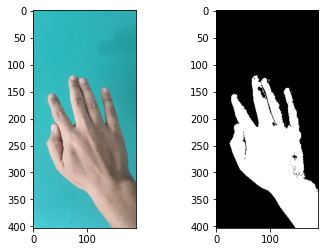

In [10]:
mask = condition(train_imgs[0][1]).squeeze(axis=2)
# nucleu = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
# mask = cv2.morphologyEx(mask.astype(np.float32), cv2.MORPH_CLOSE, nucleu,iterations=2)
plt.figure()
plt.subplot(121);plt.imshow(train_imgs[0][1][...,::-1])
plt.subplot(122);plt.imshow(mask,cmap='gray')

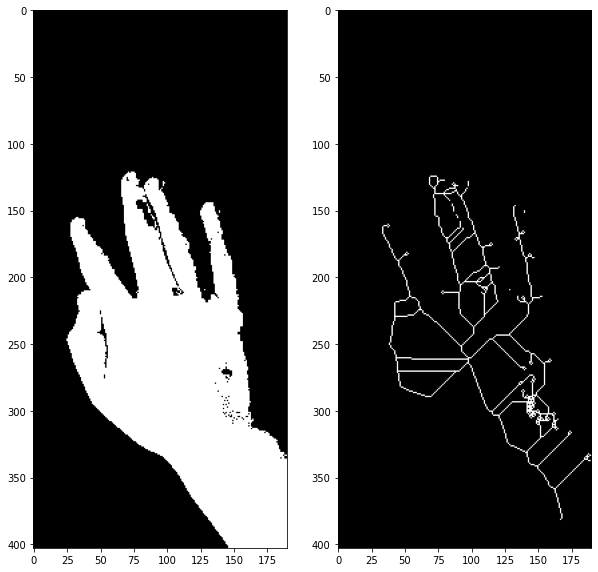

In [ ]:
from skimage.morphology import skeletonize

mask2 = skeletonize(mask, method='zhang')
plt.figure(figsize=(10,20))
plt.subplot(121);plt.imshow(mask,cmap='gray')
plt.subplot(122);plt.imshow(mask2,cmap='gray')

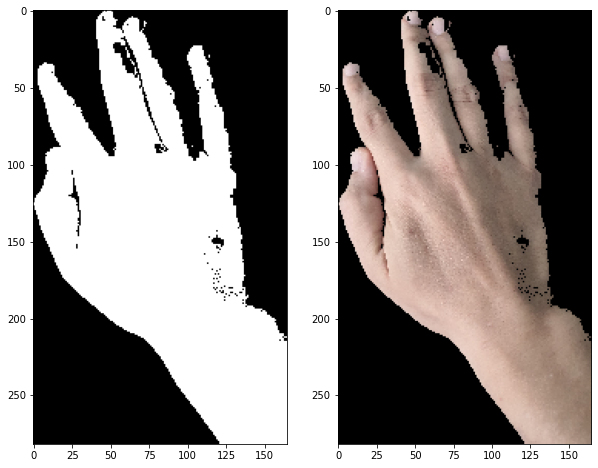

In [11]:
# gasim punctele din imagine care definesc conturul mainii
contours, hierarchy = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
img_copy = train_imgs[0][1].copy()[...,::-1]
# cv2.drawContours(img_copy, contours[3], -1, (0,255,0), 3)
# plt.figure(figsize=(10,20))
# plt.imshow(img_copy)


# bazandu-ne pe contururi cautam bounding box-ul cu cea mai mare arie
dreptunghi = None
maxArea = 0
indice = 0
for i,cont in enumerate(contours):
  tmp = cv2.boundingRect(cont)
  if maxArea < tmp[2] * tmp[3]:
    maxArea = tmp[2] * tmp[3]
    dreptunghi = tmp
    indice = i

dr = dreptunghi
cv2.rectangle(img_copy,(dr[0],dr[1]),(dr[0]+dr[2],dr[1]+dr[3]),(0,255,0),2)

img_copy = img_copy[dreptunghi[1]:dreptunghi[1]+dreptunghi[3],dreptunghi[0]:dreptunghi[0] + dreptunghi[2]]
mask = mask[dreptunghi[1]:dreptunghi[1]+dreptunghi[3],dreptunghi[0]:dreptunghi[0] + dreptunghi[2]]

img_copy[mask==0] = 0

plt.figure(figsize=(10,20))
plt.subplot(121);plt.imshow(mask,cmap='gray')
plt.subplot(122);plt.imshow(img_copy,cmap='gray')




(9360, 1)


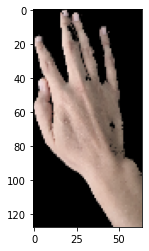

In [16]:
height = 128
width = 64
img_copy = cv2.resize(img_copy,(width,height))
plt.figure()
plt.imshow(img_copy)

winSize = (32,32)
blockSize = (32,32)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)

descriptor = hog.compute(img_copy)
